Import the necessary Library

In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

2023-11-30 12:47:36.905668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 12:47:36.905699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 12:47:36.905728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 12:47:36.911855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2023-11-30 12:47:37.471968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('/home/gdt-ws4/Desktop/tm_data.csv')

In [10]:
df

,Unnamed: 0,Protein ID,simple_fasta,Species,Tm
0,0,Q9M9P0_EXPA13,MQRFLLPLLFLALSPPAICHYSSSTSSPSSSSVSSDASEWRPARAT...,A.thaliana,40.301000
1,1,Q9LY74_VTE3,MASLMLNGAITFPKGLGSPGSNLHARSIPRPTLLSVTRTSTPRLSV...,A.thaliana,38.410000
2,2,O65784_CYP71B5,MSIFLCFLLLLPLSLIFLKKLLPSKGKLPPGPKGLPIIGNLHQFGR...,A.thaliana,36.698000
3,3,Q7XJ60_EB1A,MATNIGMMDSAYFVGRNEILTWINDRLHLNLSRVEEAASGAVQCQM...,A.thaliana,39.462000
4,4,Q8W4M5_PFP-BETA1,MAPALAVTRDLTAVGSPENAPAKGRASVYSEVQSSRINNTLPLPSV...,A.thaliana,41.074000
...,...,...,...,...,...
33227,33227,Q9WX76,MTLKELYAETRSHMQKSLEVLEHNLAGLRTGRANPALLLHLKVEYY...,T.thermophilus,85.923966
33228,33228,Q9X9D5,MSHEAVWQHVLEHIRRSITEVEFHTWFERIRPLGIRDGVLELAVPT...,T.thermophilus,68.051470
33229,33229,Q9Z9H5,MRHLKSGRKLNRHSSHRLALYRNQAKSLLTHGRITTTVPKAKELRG...,T.thermophilus,89.246662
33230,33230,Q9ZND4,MLEKFTVIRGKAVPLRGEDIDTDRILPARFMKVLTFEGLGQYLFYD...,T.thermophilus,82.160759


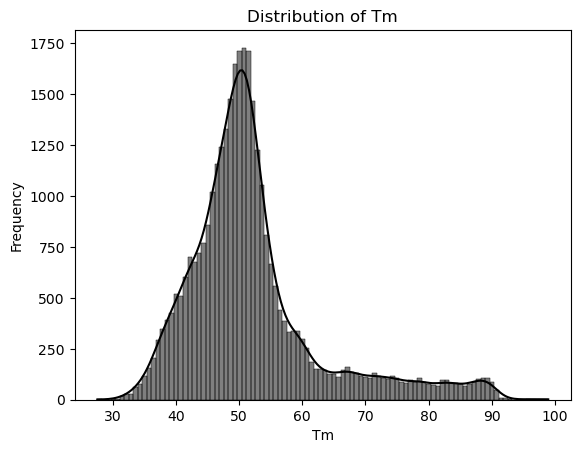

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the histogram plot
sns.histplot(df['Tm'], bins=100, kde=True,color='black')

# Add labels and title
plt.xlabel('Tm')  # Update the label for 'Tm'
plt.ylabel('Frequency')
plt.title('Distribution of Tm')

# Display the plot
plt.show()


Make the fasta file so we can Extract the features of protein sequence

In [1]:
with open('result.fasta', 'w') as fasta_file:
    for i in range(len(df)):
        protein_id = df.loc[i, 'Protein ID']
        print(protein_id)
        simple_fasta = df.loc[i, 'simple_fasta']
        
        # Write the protein information in the specified format
        fasta_file.write(f'>{protein_id}\n')
        fasta_file.write(f'{simple_fasta}\n')


NameError: name 'df' is not defined

Get the all feature and make a new dataframe with protein name and feature 

In [8]:
import os
os.chdir('/home/gdt-ws4/Desktop/all_data_feature/')

In [9]:
import pandas as pd
import glob
from functools import reduce

# List all TSV files in the current directory
tsv_files = glob.glob("*.tsv")

# Create an empty list to hold the DataFrame objects
merged_df = []

# Iterate through each TSV file and append the DataFrame to the list
for tsv_file in tsv_files:
    dfs = pd.read_csv(tsv_file, sep="\t")
    merged_df.append(dfs)

# Define a function to merge two DataFrames based on 'name' column
def merge_dataframes(df1, df2):
    return pd.merge(df1, df2, on='name')

# Use reduce to iteratively merge DataFrames in the list
final_merged_df = reduce(merge_dataframes, merged_df)

# Save the final merged DataFrame to a TSV file
#final_merged_df.to_csv("final_merged_columns.tsv", sep="\t", index=False)


In [6]:
final_merged_df.drop(columns = {'Unnamed: 241'},inplace=True)

Append all feature into list 

In [7]:
all_df = []
identifier_column = final_merged_df.iloc[:, 0]
    # Construct the column name based on the file count
column_name = 'Feature' + str(len(all_df) + 1)

# Concatenate all columns (except the first one, which contains identifiers) and store the result in a new DataFrame
feature_df = final_merged_df.iloc[:, 1:].apply(lambda x: x.to_list(), axis=1).to_frame(name=column_name)

# Add the 'Identifier' column to the feature DataFrame
feature_df.insert(0, 'Protein ID', identifier_column)
all_df.append(feature_df)


In [7]:
feature_df

,Protein ID,Feature1
0,Q9M9P0_EXPA13,"[0.00754717, 0.00754717, 0.003773585, 0.0, 0.0..."
1,Q9LY74_VTE3,"[0.005934718, 0.002967359, 0.005934718, 0.0029..."
2,O65784_CYP71B5,"[0.004024145, 0.0, 0.002012072, 0.002012072, 0..."
3,Q7XJ60_EB1A,"[0.007272727, 0.0, 0.0, 0.007272727, 0.0, 0.0,..."
4,Q8W4M5_PFP-BETA1,"[0.005309735, 0.003539823, 0.0, 0.008849558, 0..."
...,...,...
33227,Q9WX76,"[0.0, 0.0, 0.005434783, 0.02717391, 0.0, 0.005..."
33228,Q9X9D5,"[0.009195402, 0.002298851, 0.004597701, 0.0091..."
33229,Q9Z9H5,"[0.0, 0.0, 0.0, 0.008547009, 0.0, 0.0, 0.0, 0...."
33230,Q9ZND4,"[0.0, 0.0, 0.0, 0.005, 0.0, 0.01, 0.0, 0.015, ..."


In [8]:
del final_merged_df

In [9]:
df

,Unnamed: 0,Protein ID,simple_fasta,Species,Tm
0,0,Q9M9P0_EXPA13,MQRFLLPLLFLALSPPAICHYSSSTSSPSSSSVSSDASEWRPARAT...,A.thaliana,40.301000
1,1,Q9LY74_VTE3,MASLMLNGAITFPKGLGSPGSNLHARSIPRPTLLSVTRTSTPRLSV...,A.thaliana,38.410000
2,2,O65784_CYP71B5,MSIFLCFLLLLPLSLIFLKKLLPSKGKLPPGPKGLPIIGNLHQFGR...,A.thaliana,36.698000
3,3,Q7XJ60_EB1A,MATNIGMMDSAYFVGRNEILTWINDRLHLNLSRVEEAASGAVQCQM...,A.thaliana,39.462000
4,4,Q8W4M5_PFP-BETA1,MAPALAVTRDLTAVGSPENAPAKGRASVYSEVQSSRINNTLPLPSV...,A.thaliana,41.074000
...,...,...,...,...,...
33227,33227,Q9WX76,MTLKELYAETRSHMQKSLEVLEHNLAGLRTGRANPALLLHLKVEYY...,T.thermophilus,85.923966
33228,33228,Q9X9D5,MSHEAVWQHVLEHIRRSITEVEFHTWFERIRPLGIRDGVLELAVPT...,T.thermophilus,68.051470
33229,33229,Q9Z9H5,MRHLKSGRKLNRHSSHRLALYRNQAKSLLTHGRITTTVPKAKELRG...,T.thermophilus,89.246662
33230,33230,Q9ZND4,MLEKFTVIRGKAVPLRGEDIDTDRILPARFMKVLTFEGLGQYLFYD...,T.thermophilus,82.160759


In [16]:
feature_df['simple_fasta']=df['simple_fasta'].copy()
feature_df['Tm'] = df['Tm'].copy()
feature_df['seq_len'] = feature_df['simple_fasta'].apply(len)
feature_df['normTm'] =  (feature_df['Tm']/ feature_df['seq_len'])*10
feature_df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            33222, 33223, 33224, 33225, 33226, 33227, 33228, 33229, 33230,
            33231],
           dtype='int64', length=33232)

In [17]:
feature_df['seq_len']

0        266
1        338
2        498
3        276
4        566
        ... 
33227    185
33228    436
33229    118
33230    201
33231    472
Name: seq_len, Length: 33232, dtype: int64

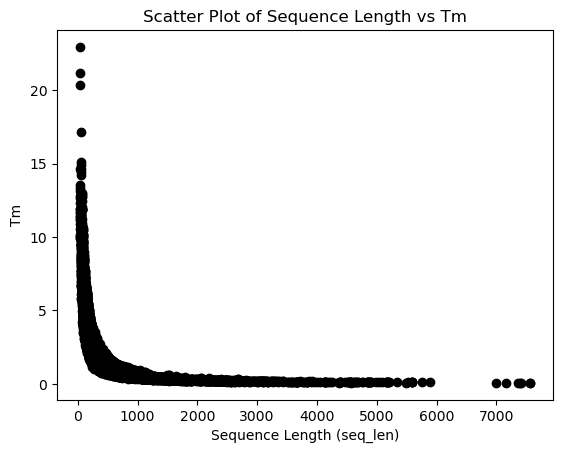

In [18]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.scatter(feature_df['seq_len'], feature_df['normTm'],color='black')  # Use 'tm value' as the y-axis label

# Add labels for the x and y axes
plt.xlabel('Sequence Length (seq_len)')
plt.ylabel('Tm')  # Update the y-axis label

# Add a title to the plot
plt.title('Scatter Plot of Sequence Length vs Tm')

# Display the plot
plt.show()


In [19]:
feature_df

,Protein ID,Feature1,simple_fasta,Tm,seq_len,normTm
0,Q9M9P0_EXPA13,"[0.00754717, 0.00754717, 0.003773585, 0.0, 0.0...",MQRFLLPLLFLALSPPAICHYSSSTSSPSSSSVSSDASEWRPARAT...,40.301000,266,1.515075
1,Q9LY74_VTE3,"[0.005934718, 0.002967359, 0.005934718, 0.0029...",MASLMLNGAITFPKGLGSPGSNLHARSIPRPTLLSVTRTSTPRLSV...,38.410000,338,1.136391
2,O65784_CYP71B5,"[0.004024145, 0.0, 0.002012072, 0.002012072, 0...",MSIFLCFLLLLPLSLIFLKKLLPSKGKLPPGPKGLPIIGNLHQFGR...,36.698000,498,0.736908
3,Q7XJ60_EB1A,"[0.007272727, 0.0, 0.0, 0.007272727, 0.0, 0.0,...",MATNIGMMDSAYFVGRNEILTWINDRLHLNLSRVEEAASGAVQCQM...,39.462000,276,1.429783
4,Q8W4M5_PFP-BETA1,"[0.005309735, 0.003539823, 0.0, 0.008849558, 0...",MAPALAVTRDLTAVGSPENAPAKGRASVYSEVQSSRINNTLPLPSV...,41.074000,566,0.725689
...,...,...,...,...,...,...
33227,Q9WX76,"[0.0, 0.0, 0.005434783, 0.02717391, 0.0, 0.005...",MTLKELYAETRSHMQKSLEVLEHNLAGLRTGRANPALLLHLKVEYY...,85.923966,185,4.644539
33228,Q9X9D5,"[0.009195402, 0.002298851, 0.004597701, 0.0091...",MSHEAVWQHVLEHIRRSITEVEFHTWFERIRPLGIRDGVLELAVPT...,68.051470,436,1.560814
33229,Q9Z9H5,"[0.0, 0.0, 0.0, 0.008547009, 0.0, 0.0, 0.0, 0....",MRHLKSGRKLNRHSSHRLALYRNQAKSLLTHGRITTTVPKAKELRG...,89.246662,118,7.563276
33230,Q9ZND4,"[0.0, 0.0, 0.0, 0.005, 0.0, 0.01, 0.0, 0.015, ...",MLEKFTVIRGKAVPLRGEDIDTDRILPARFMKVLTFEGLGQYLFYD...,82.160759,201,4.087600


In [20]:
import ast
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
protein_sequences = feature_df['Feature1']
Tm = feature_df['normTm']

# Preprocess protein sequences
protein_sequences = [list(filter(lambda x: not math.isnan(x), seq)) for seq in protein_sequences]
encoded_sequences = [np.array(seq, dtype=np.float32) for seq in protein_sequences]

# Convert the lists to NumPy float arrays
X = encoded_sequences
X = np.array(X)
y = np.array(Tm)
# Initialize the LabelEncoder
# label_encoder = LabelEncoder()

# # Fit the LabelEncoder on your category labels
# label_encoder.fit(Tm)

# # Convert the category labels to encoded numeric labels
# y = label_encoder.transform(Tm)


In [21]:

del protein_sequences
del delta_g_values
del encoded_sequences
del padded_sequences


NameError: name 'delta_g_values' is not defined

In [22]:
#splitting the data into test set and  train set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#for valdiation part data in 30% exclude from 100% and 70% is for training
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=52)

# # Split the remaining data (30%) into 10% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=52)

# Print the shapes of the datasets
print("Training data shapes:", X_train.shape, y_train.shape)

print("Validation data shapes:", X_val.shape, y_val.shape)
print("Test data shapes:", X_test.shape, y_test.shape)


Training data shapes: (23262, 9430) (23262,)
Validation data shapes: (3290, 9430) (3290,)
Test data shapes: (6680, 9430) (6680,)


In [23]:
# Set the input shape and number of classes (1 for regression)
input_shape = (X_train.shape[1:],1)
num_classes = 1

# Create the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='linear'))  # Using 'linear' activation for regression

# Compile the model with appropriate loss function and optimizer
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Apply learning rate scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

# Train the model using the training dataset and validate on the validation set
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_scheduler])


2023-11-30 12:58:14.789164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 12:58:14.899177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 12:58:14.899636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-11-30 12:58:18.860599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 12:58:21.018086: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x839519e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 12:58:21.018114: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-30 12:58:21.037164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 12:58:21.141257: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


727/727 [==============================] - 22s 23ms/step - loss: 3200.0530 - val_loss: 1.9139 - lr: 0.0010
Epoch 2/100
727/727 [==============================] - 16s 22ms/step - loss: 10.1724 - val_loss: 2.3144 - lr: 0.0010
Epoch 3/100
727/727 [==============================] - 16s 22ms/step - loss: 4.2831 - val_loss: 1.5140 - lr: 0.0010
Epoch 4/100
727/727 [==============================] - 16s 22ms/step - loss: 2.1221 - val_loss: 0.6009 - lr: 0.0010
Epoch 5/100
727/727 [==============================] - 16s 22ms/step - loss: 1.9297 - val_loss: 0.7263 - lr: 0.0010
Epoch 6/100
727/727 [==============================] - 16s 22ms/step - loss: 1.8530 - val_loss: 0.6613 - lr: 0.0010
Epoch 7/100
727/727 [==============================] - 16s 22ms/step - loss: 1.7241 - val_loss: 0.5980 - lr: 0.0010
Epoch 8/100
727/727 [==============================] - 16s 22ms/step - loss: 1.6578 - val_loss: 0.5549 - lr: 0.0010
Epoch 9/100
727/727 [==============================] - 16s 22ms/step - loss: 1.4

KeyboardInterrupt: 

In [24]:
from tensorflow import keras

# Load the model
model = keras.models.load_model('predict_tm_new.h5')


In [25]:
# Assuming you have predictions and true values as numpy arrays
prediction = model.predict(X_test)
y_true = np.array(y_test)  # True delta_G values for the test data
y_pred = prediction.reshape(-1)  # Reshape predictions to a 1D array if needed

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate coefficient of determination (R-squared score)
r2_score_value = r2_score(y_true, y_pred)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("R-squared Score:", r2_score_value)


  1/209 [..............................] - ETA: 13s

2023-11-30 13:04:50.177232: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251969600 exceeds 10% of free system memory.


209/209 [==============================] - 1s 5ms/step
Mean Squared Error (MSE): 0.1585490271455706
R-squared Score: 0.9226885295412338


In [23]:
model.save("predict_tm_new.h5")

/home/gdt-ws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
df = pd.DataFrame({'Protein ID':['2A36_1','1UBQ_1','1F21_1'],
'simple_fasta':['MEAIAKHDFSATADDELSFRKTQILKILNMEDDSNWYRAELDGKEGLIPSNYIEMKNHD','MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG','MLKQVEIFTDGSALGNPGPGGYGAILRYRGREKTFSAGYTRTTNNRMELMAAIVALEALKEHAEVILSTDSQYVRQGITQWIHNWKKRGWKTADKKPVKNVDLWQRLDAALGQHQIKWEWVKGHAGHPENERADELARAAAMNPTLEDTGYQVEV']})



In [25]:
df

,Protein ID,simple_fasta
0,2A36_1,MEAIAKHDFSATADDELSFRKTQILKILNMEDDSNWYRAELDGKEG...
1,1UBQ_1,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFA...
2,1F21_1,MLKQVEIFTDGSALGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...


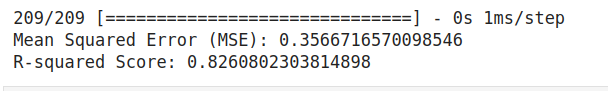

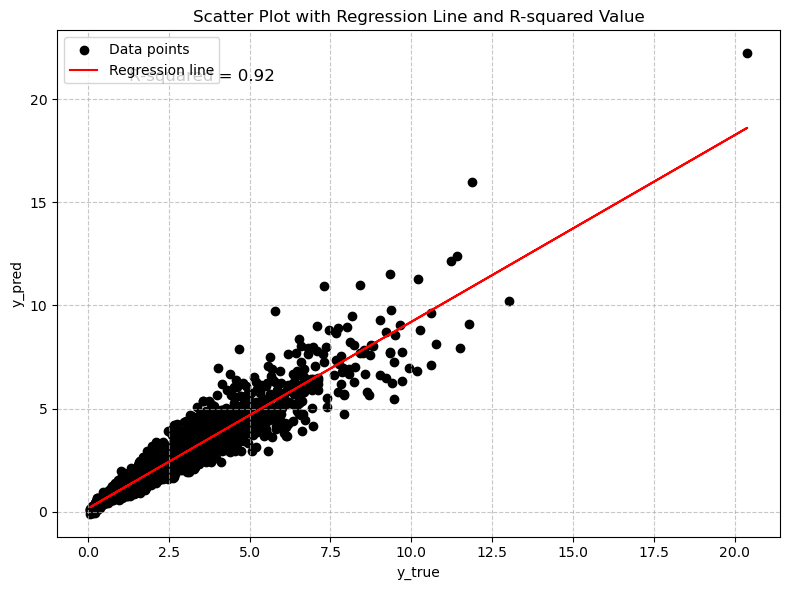

In [26]:
import matplotlib.pyplot as plt
regression_line = np.polyfit(y_true, y_pred, 1)
regression_fn = np.poly1d(regression_line)

# Calculate the R-squared value
r2 = r2_score(y_true, y_pred)

# Create a scatter plot with regression line and R-squared value
plt.figure(figsize=(8, 6))

plt.scatter(y_true, y_pred, color='black', label='Data points')
plt.plot(y_true, regression_fn(y_true), color='red', label='Regression line')

# Annotate with R-squared value
plt.annotate(f'R-squared = {r2:.2f}', (0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Scatter Plot with Regression Line and R-squared Value')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



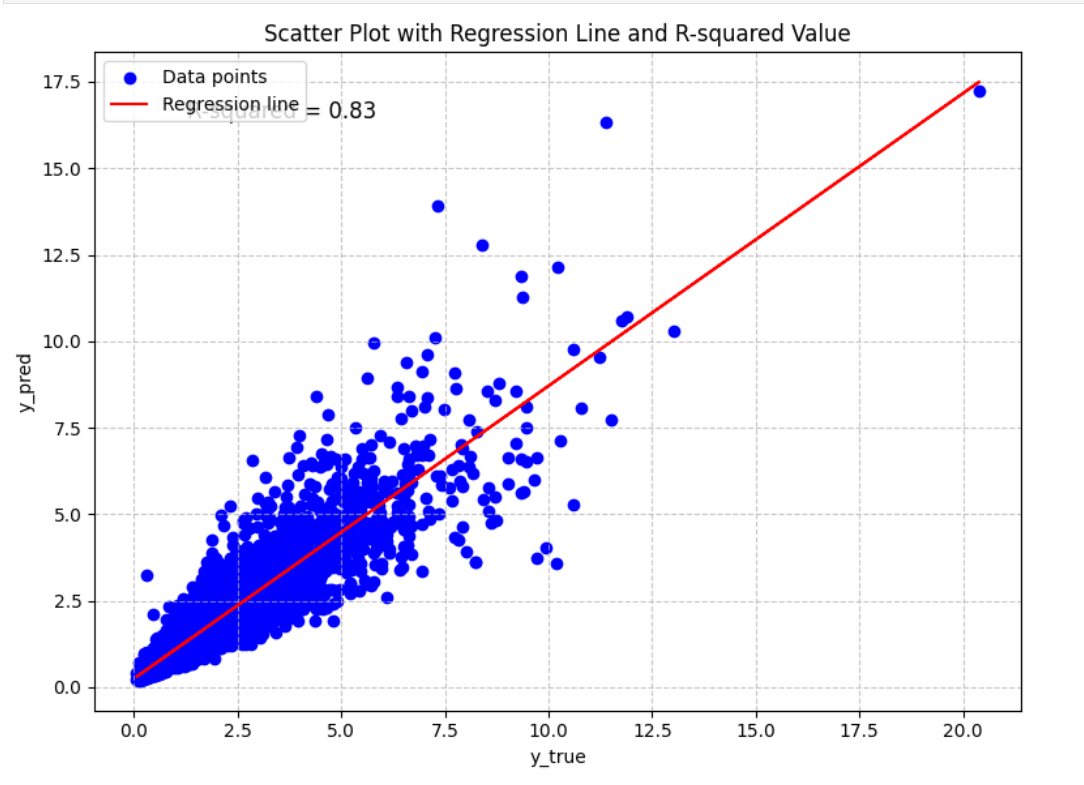

In [ ]:
model.save("predict_tm.h5")

3 Cross validation of same dataset

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Set the input shape and number of classes (1 for regression)
input_shape = (X_train.shape[1:])
num_classes = 1

# Create the model architecture
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

# Initialize lists to store R2 scores for each fold
r2_scores = []
mse = []
# Create a KFold cross-validator
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate through cross-validation folds
for train_idx, val_idx in kf.split(X_train):
    # Split the data into train and validation sets for this fold
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    print(X_fold_train.shape)
    # Create a new instance of the model for each fold
    model = create_model()
   
    
    # Train the model on the current fold's training data
    model.fit(X_fold_train, y_fold_train, epochs=100, batch_size=64, validation_data=(X_fold_val, y_fold_val))
    
    # Evaluate the model on the current fold's validation data
    y_fold_val_pred = model.predict(X_fold_val)
    mse_i = mean_squared_error(y_fold_val, y_fold_val_pred)
    r2 = r2_score(y_fold_val, y_fold_val_pred)
    print(r2)
    r2_scores.append(r2)
    mse.append(mse_i)
    

# Calculate the mean and standard deviation of R2 scores
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mse_m = np.mean(mse)
print(f"Mean R2 across {num_folds} folds: {mean_r2:.4f}")
print(f"Standard Deviation of R2: {std_r2:.4f}")
print(f"mean of mean square error : {mse_m:.4f}")


Mean R2 across 3 folds: 0.8160
Standard Deviation of R2: 0.0018
mean of mean square error : 0.3856

In [2]:
r2_scores



[0.8135616935720141, 0.8178967921865654, 0.8164053008395661]

test data

In [26]:
df = pd.DataFrame({'Protein ID':['2A36_1','1UBQ_1','1F21_1'],
'simple_fasta':['MEAIAKHDFSATADDELSFRKTQILKILNMEDDSNWYRAELDGKEGLIPSNYIEMKNHD','MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG','MLKQVEIFTDGSALGNPGPGGYGAILRYRGREKTFSAGYTRTTNNRMELMAAIVALEALKEHAEVILSTDSQYVRQGITQWIHNWKKRGWKTADKKPVKNVDLWQRLDAALGQHQIKWEWVKGHAGHPENERADELARAAAMNPTLEDTGYQVEV']})



In [27]:
df

,Protein ID,simple_fasta
0,2A36_1,MEAIAKHDFSATADDELSFRKTQILKILNMEDDSNWYRAELDGKEG...
1,1UBQ_1,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFA...
2,1F21_1,MLKQVEIFTDGSALGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...


In [28]:
with open('result_test.fasta', 'w') as fasta_file:
    for i in range(len(df)):
        protein_id = df.loc[i, 'Protein ID']
        print(protein_id)
        simple_fasta = df.loc[i, 'simple_fasta']
        
        # Write the protein information in the specified format
        fasta_file.write(f'>{protein_id}\n')
        fasta_file.write(f'{simple_fasta}\n')


2A36_1
1UBQ_1
1F21_1


In [29]:
import os
os.chdir('/home/gdt-ws4/Desktop/all_data_feature1/')

In [30]:
import pandas as pd
import glob
from functools import reduce

# List all TSV files in the current directory
tsv_files = glob.glob("*.tsv")

# Create an empty list to hold the DataFrame objects
merged_df = []

# Iterate through each TSV file and append the DataFrame to the list
for tsv_file in tsv_files:
    dfs = pd.read_csv(tsv_file, sep="\t")
    merged_df.append(dfs)

# Define a function to merge two DataFrames based on 'name' column
def merge_dataframes(df1, df2):
    return pd.merge(df1, df2, on='name')

# Use reduce to iteratively merge DataFrames in the list
final_merged_df = reduce(merge_dataframes, merged_df)

# Save the final merged DataFrame to a TSV file
#final_merged_df.to_csv("final_merged_columns.tsv", sep="\t", index=False)


In [31]:
all_df = []
identifier_column = final_merged_df.iloc[:, 0]
    # Construct the column name based on the file count
column_name = 'Feature' + str(len(all_df) + 1)

# Concatenate all columns (except the first one, which contains identifiers) and store the result in a new DataFrame
feature_df = final_merged_df.iloc[:, 1:].apply(lambda x: x.to_list(), axis=1).to_frame(name=column_name)

# Add the 'Identifier' column to the feature DataFrame
feature_df.insert(0, 'Protein ID', identifier_column)
all_df.append(feature_df)


In [39]:
x_t = feature_df['Feature1']

In [46]:
prediction = model.predict(x_t)


1/1 [==============================] - 0s 112ms/step


In [44]:
protein_sequences = [list(filter(lambda x: not math.isnan(x), seq)) for seq in x_t]
encoded_sequences = [np.array(seq, dtype=np.float32) for seq in protein_sequences]
x_t = np.array(encoded_sequences)

In [45]:
x_t

array([[ 0.        ,  0.        ,  0.01724138, ...,  0.216295  ,
        -0.00476952,  0.3377434 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0149264 ,
         0.01844488,  0.09364652],
       [ 0.02597403,  0.        ,  0.01298701, ..., -0.01010565,
         0.01198997,  0.02302925]], dtype=float32)

In [47]:
y_pred = prediction.reshape(-1) 

In [48]:
y_pred

array([8.116348 , 6.9314585, 3.240933 ], dtype=float32)

In [ ]:
def tm_predict(prot_seq,pro):
    length = len(pro)
    last_prediction = (prot_seq*length)/10
    print(
    return last_prediction


feature_df['tm_prediction'] = feature_df.apply(lambda row: tm_predict(row['tm_value1'], row['mutated_sequence']), axis=1)

In [54]:
len(df['simple_fasta'][2])

155

In [55]:
(3.240933*155)/10

50.2344615